In [5]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, RocCurveDisplay
from sklearn.base import clone

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Pre Analysis

In [7]:
naticusdroid_android_permissions = fetch_ucirepo(id=722) 
  
X = naticusdroid_android_permissions.data.features 
y = naticusdroid_android_permissions.data.targets 

with pd.option_context("display.max_rows", None):
    print(naticusdroid_android_permissions.metadata)
    print(naticusdroid_android_permissions.variables)

{'uci_id': 722, 'name': 'NATICUSdroid (Android Permissions)', 'repository_url': 'https://archive.ics.uci.edu/dataset/722/naticusdroid+android+permissions+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/722/data.csv', 'abstract': 'Contains permissions extracted from more than 29000 benign & malware Android apps released between 2010-2019.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 29333, 'num_features': 86, 'feature_types': [], 'demographics': [], 'target_col': ['Result'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2021, 'last_updated': 'Tue Apr 09 2024', 'dataset_doi': '10.24432/C5FS64', 'creators': ['Akshay Mathur'], 'intro_paper': {'ID': 122, 'type': 'NATIVE', 'title': 'NATICUSdroid: A malware detection framework for Android using native and custom permissions', 'authors': 'A. Mathur, Laxmi M. Podila, Keyur Kulkarni, Quamar Niyaz, A. Javaid'

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29332 entries, 0 to 29331
Data columns (total 86 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   android.permission.GET_ACCOUNTS                                                29332 non-null  int64
 1   com.sonyericsson.home.permission.BROADCAST_BADGE                               29332 non-null  int64
 2   android.permission.READ_PROFILE                                                29332 non-null  int64
 3   android.permission.MANAGE_ACCOUNTS                                             29332 non-null  int64
 4   android.permission.WRITE_SYNC_SETTINGS                                         29332 non-null  int64
 5   android.permission.READ_EXTERNAL_STORAGE                                       29332 non-null  int64
 6   android.permission.RECEIVE_SMS        

In [9]:
with pd.option_context("display.max_rows", None):
    print(X.sum().sort_values(ascending=False))

android.permission.INTERNET                                                      28608
android.permission.ACCESS_NETWORK_STATE                                          27837
android.permission.WRITE_EXTERNAL_STORAGE                                        19629
android.permission.READ_PHONE_STATE                                              17229
android.permission.ACCESS_WIFI_STATE                                             15401
android.permission.WAKE_LOCK                                                     14105
android.permission.ACCESS_COARSE_LOCATION                                        13607
android.permission.RECEIVE_BOOT_COMPLETED                                        13342
android.permission.ACCESS_FINE_LOCATION                                          13068
android.permission.VIBRATE                                                       10238
android.permission.GET_TASKS                                                      6850
android.permission.GET_ACCOUNTS            

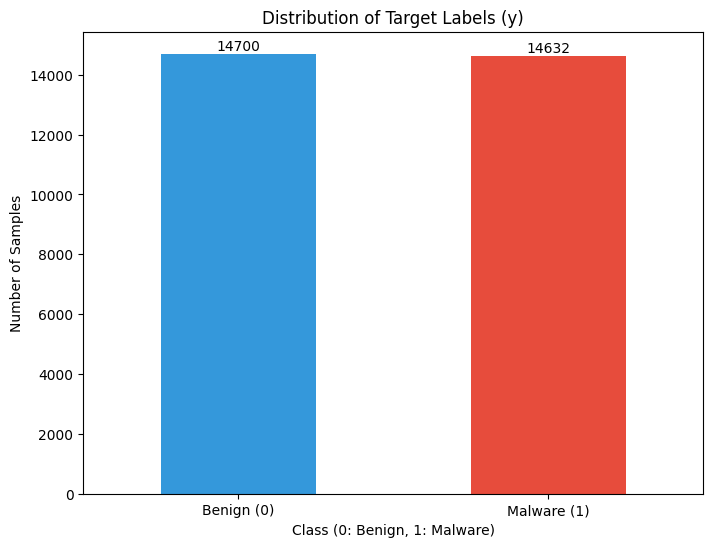

In [38]:
counts = y.value_counts()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['#3498db', '#e74c3c'])

plt.title('Distribution of Target Labels (y)')
plt.xlabel('Class (0: Benign, 1: Malware)')
plt.ylabel('Number of Samples')

plt.xticks(ticks=[0, 1], labels=['Benign (0)', 'Malware (1)'], rotation=0)

for i, v in enumerate(counts):
    plt.text(i, v + 100, str(v), ha='center')

plt.show()

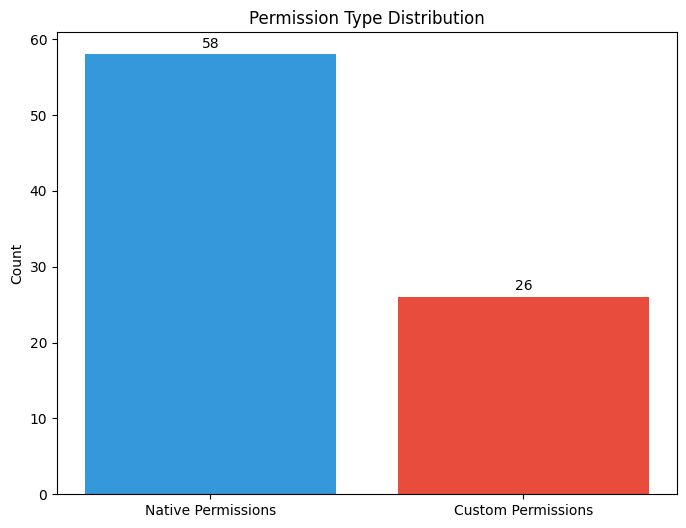

In [39]:
native = set()
custom = set()

for column in X.columns:
    if column.startswith("android"):
        native.add(column)
    elif column.startswith("com"):
        custom.add(column)

categories = ['Native Permissions', 'Custom Permissions']
counts = [len(native), len(custom)]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['#3498db', '#e74c3c'])

plt.ylabel('Count')
plt.title('Permission Type Distribution')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()

# Model Development

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

In [13]:
def evaluate(model, X, y):
    y_pred = model.predict(X)

    metrics = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Value": [
            accuracy_score(y, y_pred),
            precision_score(y, y_pred),
            recall_score(y, y_pred),
            f1_score(y, y_pred)
        ]
    }

    results_df = pd.DataFrame(metrics)
    print(results_df.to_string(index=False))

    cm = confusion_matrix(y, y_pred)

    tn, fp, fn, tp = cm.ravel()

    labels = [
        f"TN\n{tn}", f"FP\n{fp}",
        f"FN\n{fn}", f"TP\n{tp}"
    ]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False,
                xticklabels=["Benign (0)", "Malware (1)"], 
                yticklabels=["Benign (0)", "Malware (1)"])

    plt.title('NATICUSdroid Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    RocCurveDisplay.from_estimator(model, X, y)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title('ROC Curve')
    plt.show()

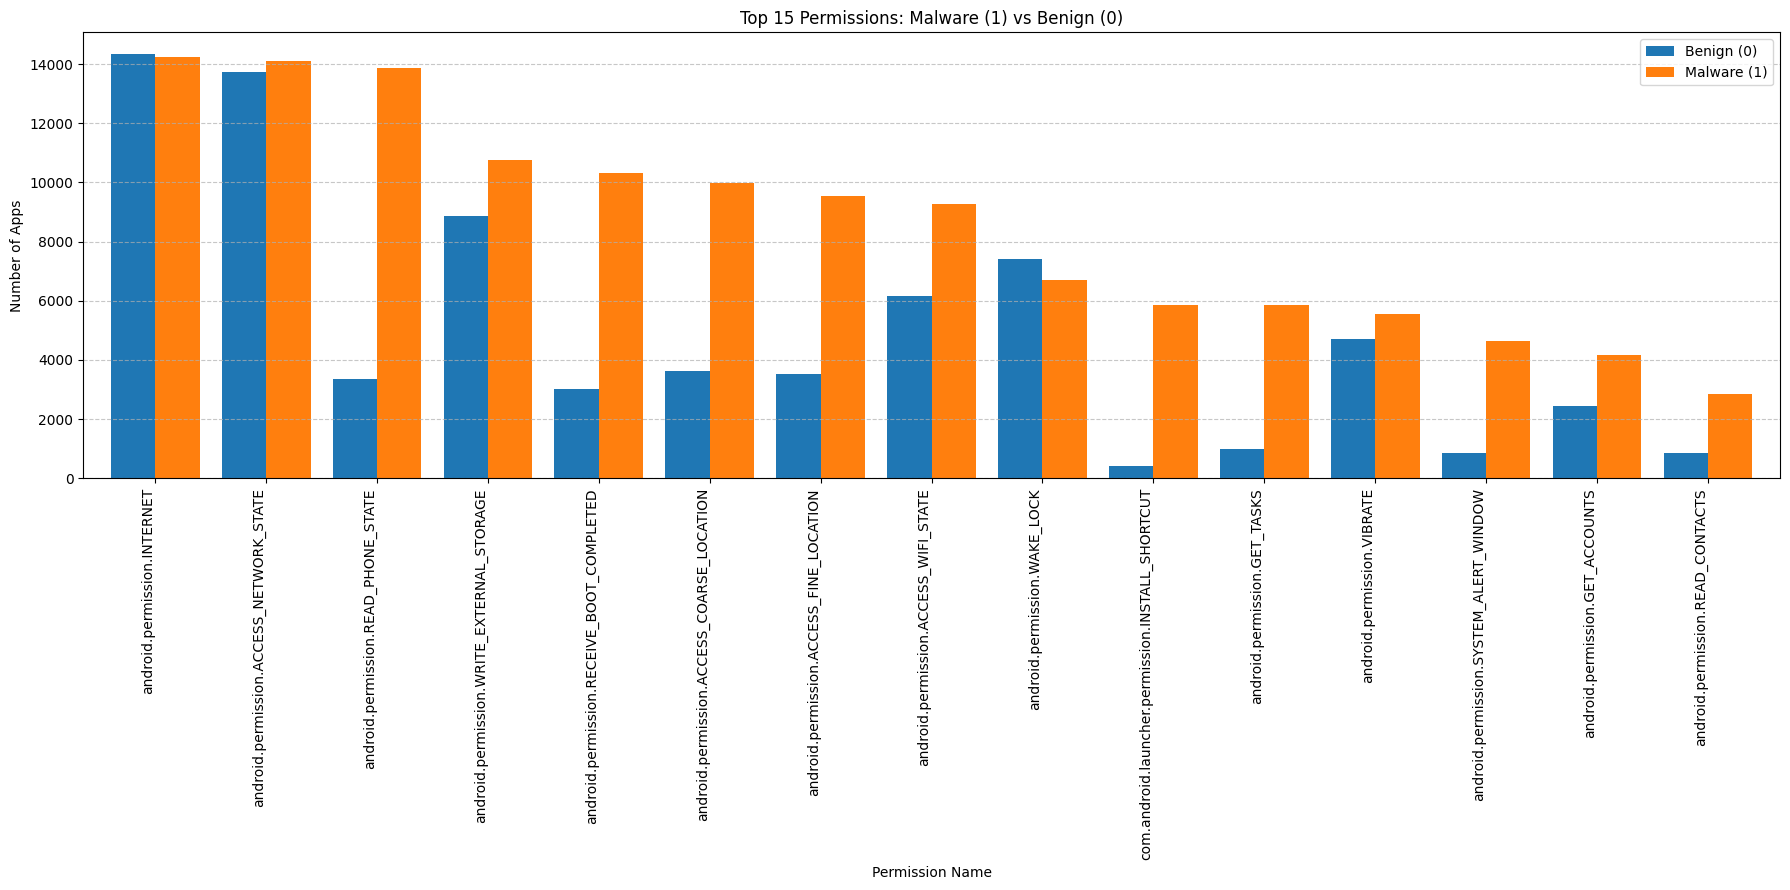

In [14]:
df = pd.concat([X, y], axis=1)
permission_counts = df.groupby("Result").sum().T
top_permissions = permission_counts.sort_values(by=1, ascending=False).head(15)

top_permissions.plot(kind='bar', figsize=(18, 9), width=0.8)

plt.title('Top 15 Permissions: Malware (1) vs Benign (0)')
plt.ylabel('Number of Apps')
plt.xlabel('Permission Name')
plt.legend(['Benign (0)', 'Malware (1)'])
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Axes: >

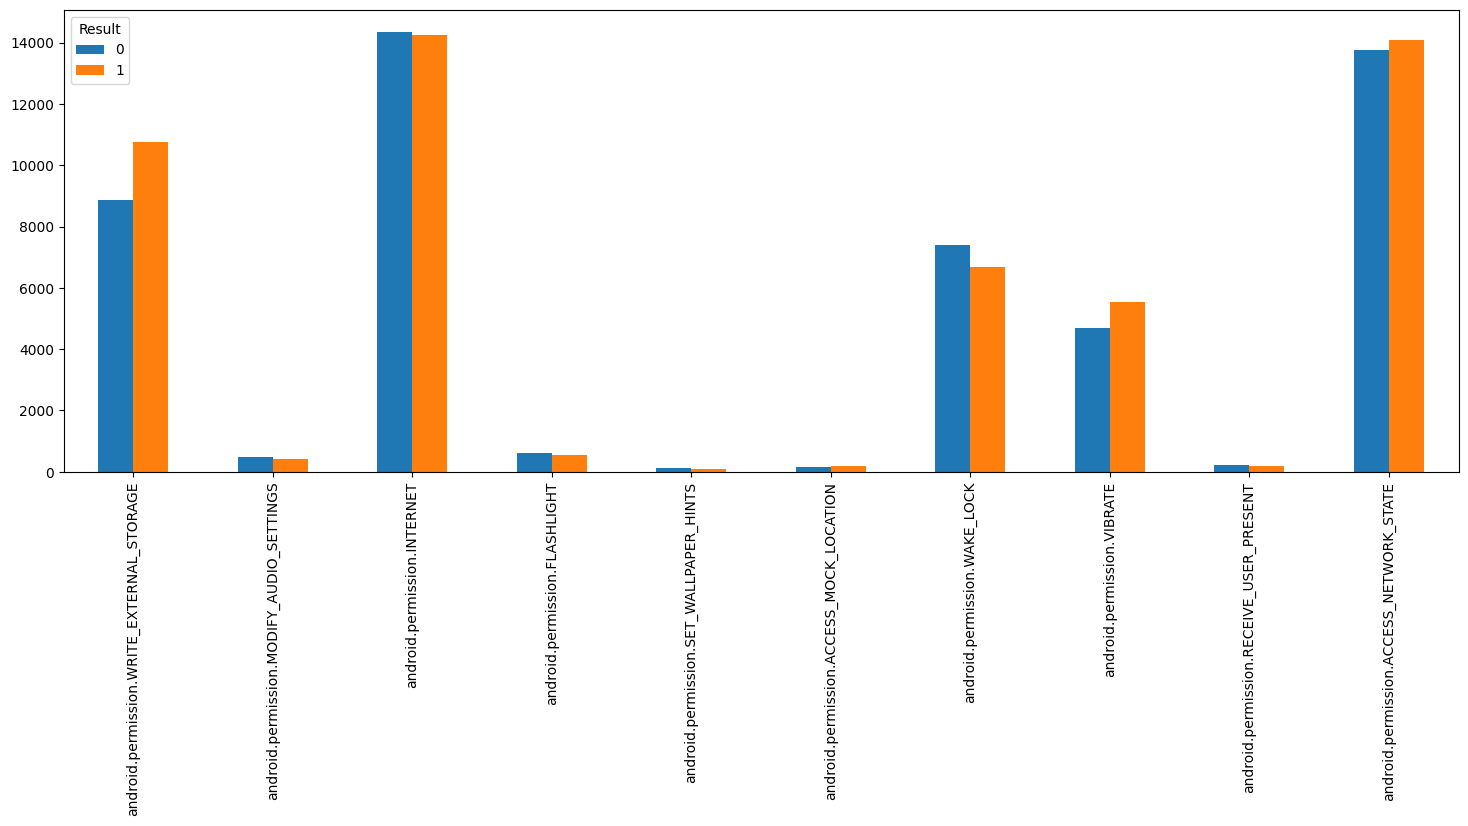

In [15]:
total_per_permission = permission_counts[0] + permission_counts[1]
permission_counts['pct_diff'] = ((permission_counts[0] - permission_counts[1]).abs() / total_per_permission) * 100
very_close = permission_counts[permission_counts['pct_diff'] < 10]
very_close.drop(columns=['pct_diff']).plot(kind='bar', figsize=(18, 6))

In [16]:
df_cleaned = df.drop(columns=very_close.index, axis=1)

X_2 = df_cleaned.drop("Result", axis=1)
y_2 = df_cleaned["Result"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.4, random_state=42)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.25, random_state=42)

## Dummy Classifer

In [17]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_model_2 = clone(dummy_model)

In [18]:
dummy_model.fit(X_train, y_train)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'most_frequent'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


   Metric    Value
 Accuracy 0.504772
Precision 0.504772
   Recall 1.000000
 F1 Score 0.670895


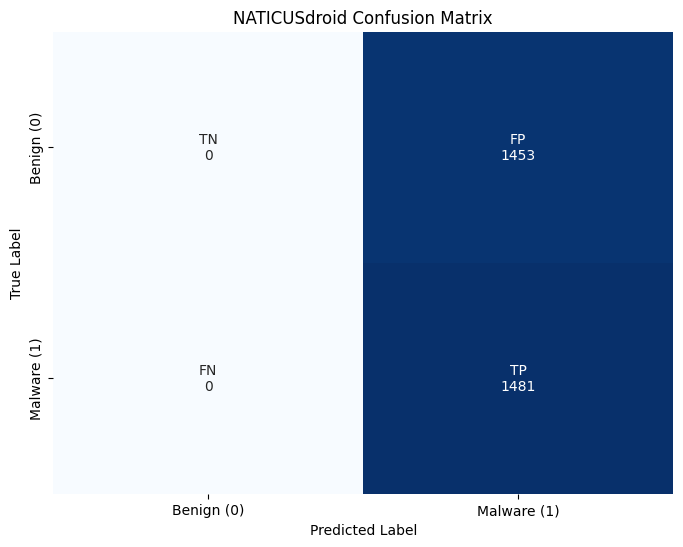

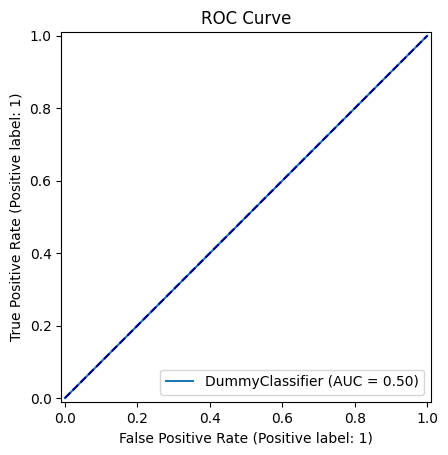

In [19]:
evaluate(model=dummy_model, X=X_val, y=y_val)

In [20]:
dummy_model_2.fit(X_train_2, y_train_2)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'most_frequent'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


   Metric    Value
 Accuracy 0.504772
Precision 0.504772
   Recall 1.000000
 F1 Score 0.670895


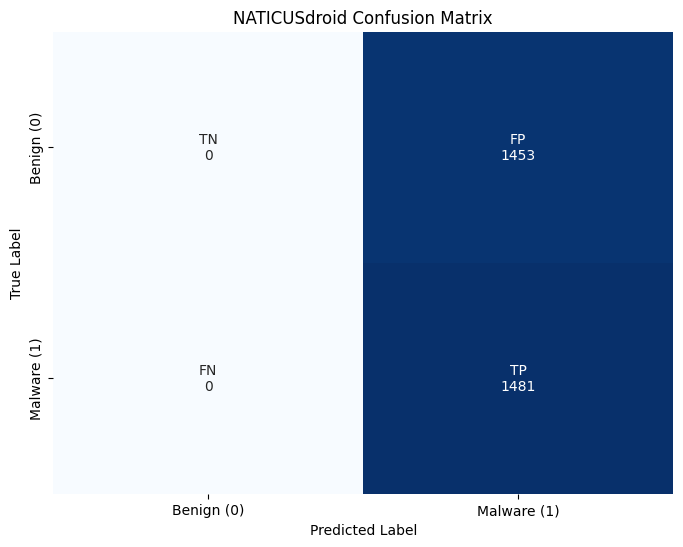

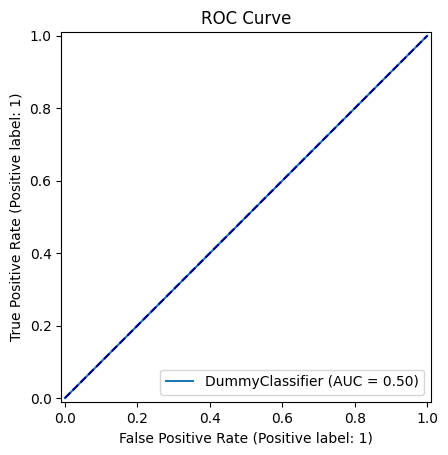

In [21]:
evaluate(model=dummy_model_2, X=X_val_2, y=y_val_2)

## XGBoost

In [47]:
xgboost_model = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8],
    'gamma': [0, 0.1, 0.2],
}

xgboost_model = RandomizedSearchCV(
    xgboost_model, 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=5, 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgboost_model_2 = clone(xgboost_model)

In [48]:
xgboost_model.fit(X_train, y_train)
print(f"Best parameters: {xgboost_model.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}


   Metric    Value
 Accuracy 0.966599
Precision 0.966285
   Recall 0.967589
 F1 Score 0.966937


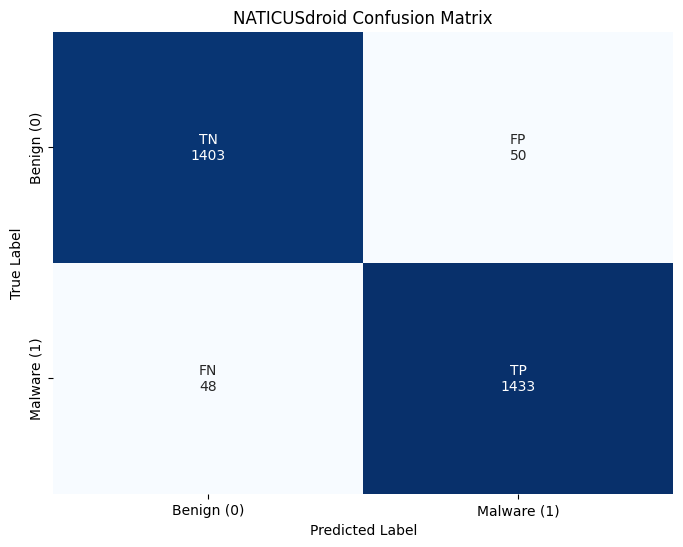

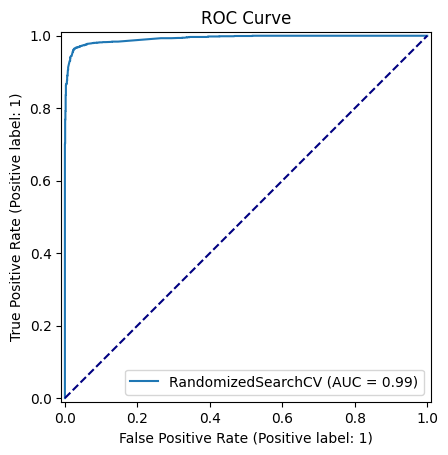

In [49]:
evaluate(model=xgboost_model, X=X_val, y=y_val)

In [50]:
xgboost_model_2.fit(X_train_2, y_train_2)
print(f"Best parameters: {xgboost_model_2.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.4}


   Metric    Value
 Accuracy 0.961827
Precision 0.958473
   Recall 0.966239
 F1 Score 0.962340


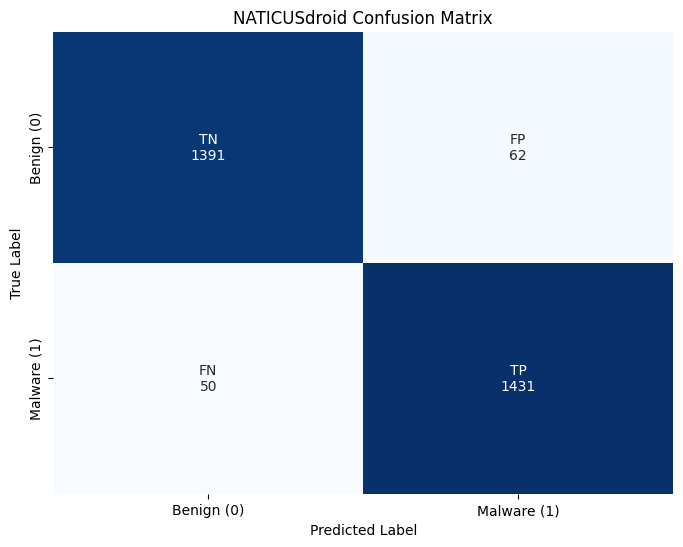

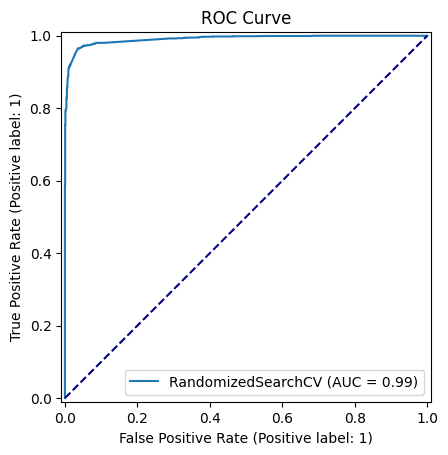

In [51]:
evaluate(model=xgboost_model_2, X=X_val_2, y=y_val_2)

## Logistic Regression

In [27]:
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logistic_regression_model = GridSearchCV(
    estimator=logistic_regression_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

logistic_regression_model_2 = clone(logistic_regression_model)

In [28]:
logistic_regression_model.fit(X_train, y_train)
print(f"Best Parameters: {logistic_regression_model.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


   Metric    Value
 Accuracy 0.958078
Precision 0.948481
   Recall 0.969615
 F1 Score 0.958932


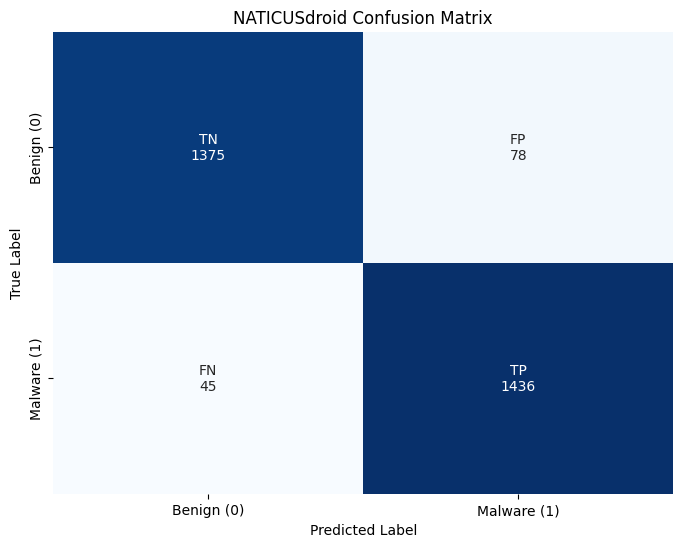

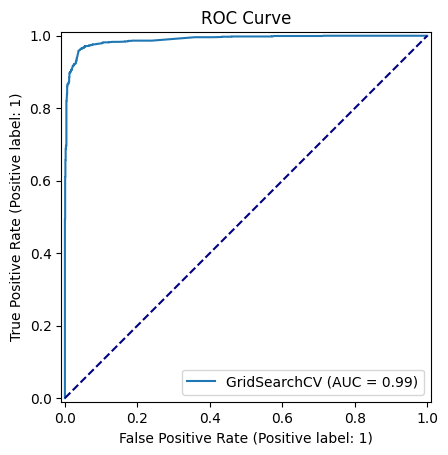

In [29]:
evaluate(model=logistic_regression_model, X=X_val, y=y_val)

In [30]:
logistic_regression_model_2.fit(X_train_2, y_train_2)
print(f"Best Parameters: {logistic_regression_model_2.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


   Metric    Value
 Accuracy 0.952965
Precision 0.943234
   Recall 0.964889
 F1 Score 0.953939


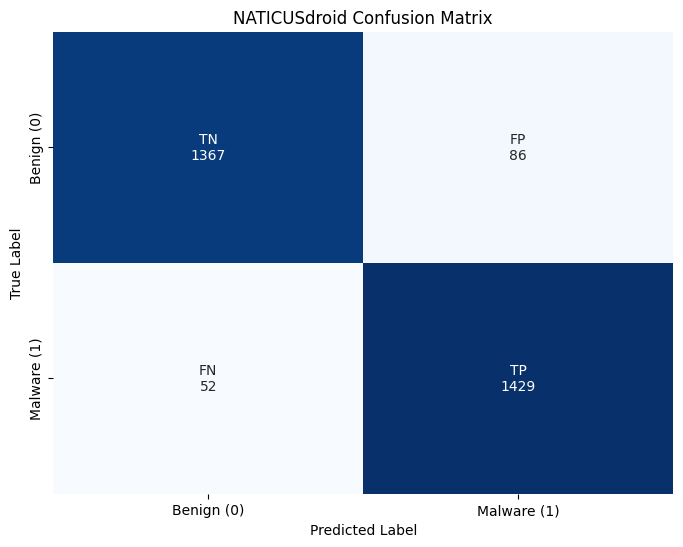

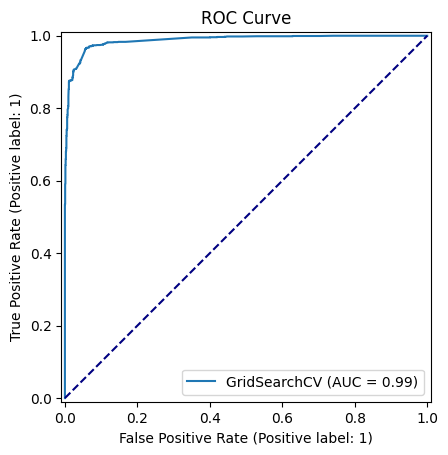

In [31]:
evaluate(model=logistic_regression_model_2, X=X_val_2, y=y_val_2)

# Testing

### Dummy Classifier

   Metric    Value
 Accuracy 0.498693
Precision 0.498693
   Recall 1.000000
 F1 Score 0.665504


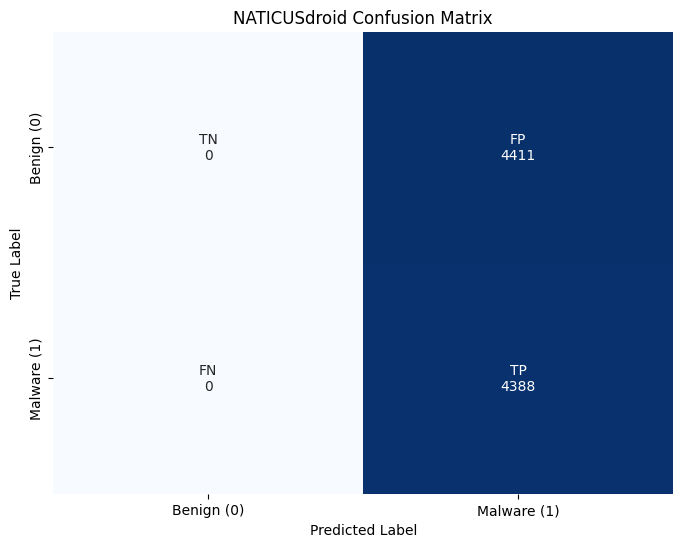

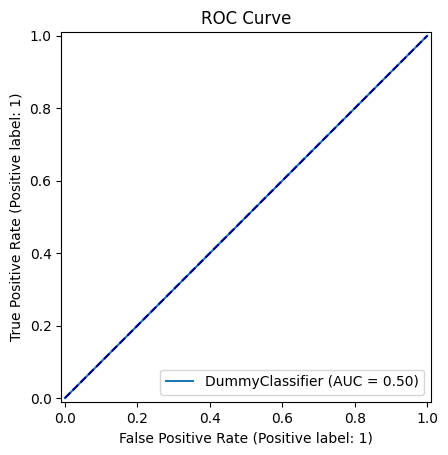

   Metric    Value
 Accuracy 0.498693
Precision 0.498693
   Recall 1.000000
 F1 Score 0.665504


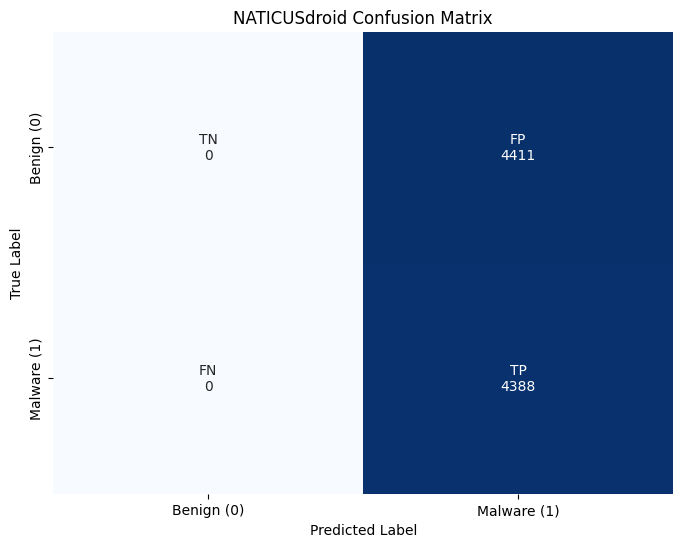

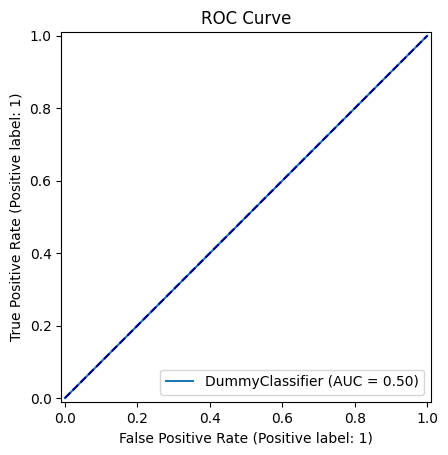

In [32]:
evaluate(model=dummy_model, X=X_test, y=y_test)
evaluate(model=dummy_model_2, X=X_test_2, y=y_test_2)

### XGBoost Classifier

   Metric    Value
 Accuracy 0.968633
Precision 0.973951
   Recall 0.962853
 F1 Score 0.968370


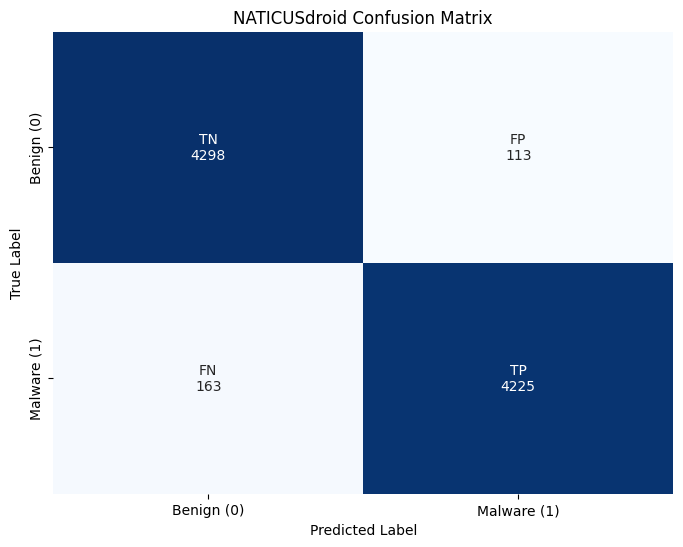

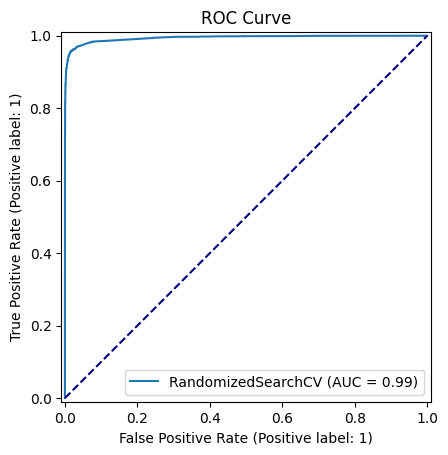

   Metric    Value
 Accuracy 0.964314
Precision 0.966988
   Recall 0.961258
 F1 Score 0.964114


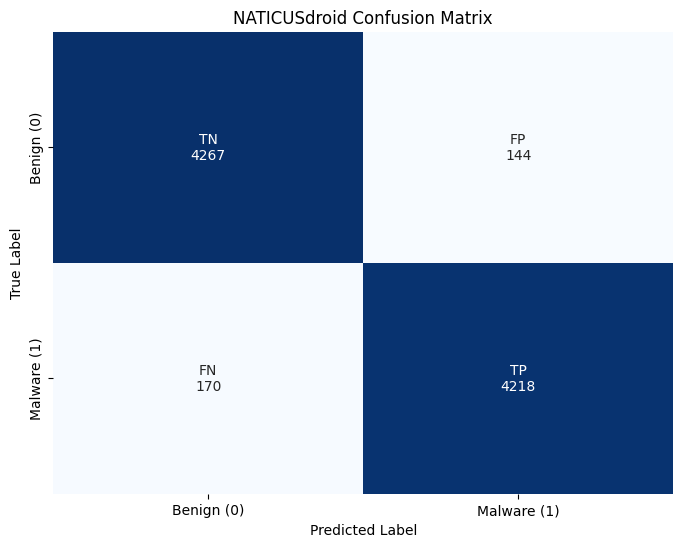

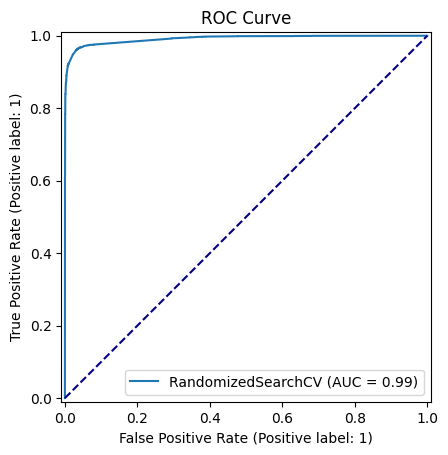

In [33]:
evaluate(model=xgboost_model, X=X_test, y=y_test)
evaluate(model=xgboost_model_2, X=X_test_2, y=y_test_2)

### Logistic Regression Classifier

   Metric    Value
 Accuracy 0.962609
Precision 0.959267
   Recall 0.966044
 F1 Score 0.962643


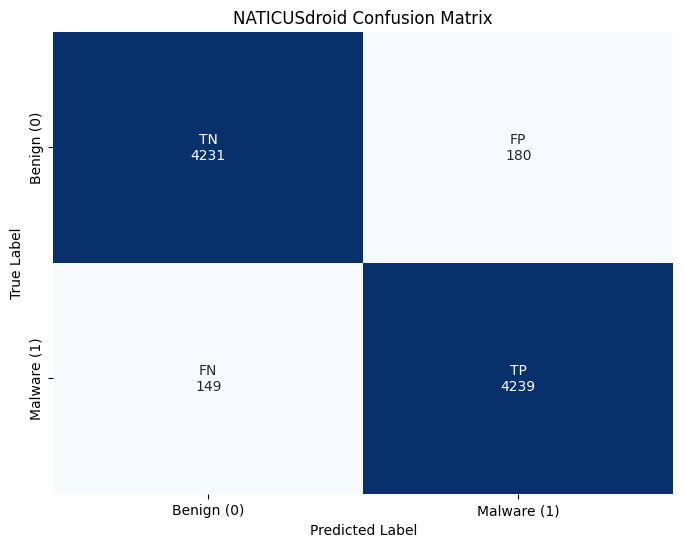

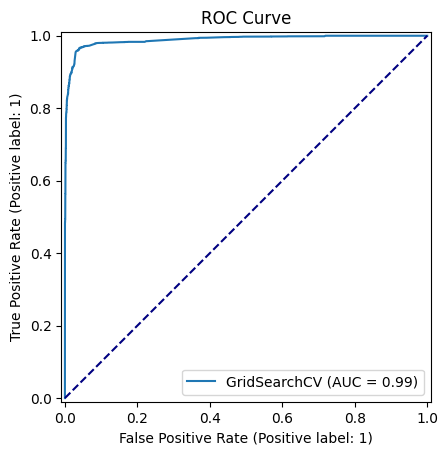

   Metric    Value
 Accuracy 0.956586
Precision 0.952962
   Recall 0.960346
 F1 Score 0.956640


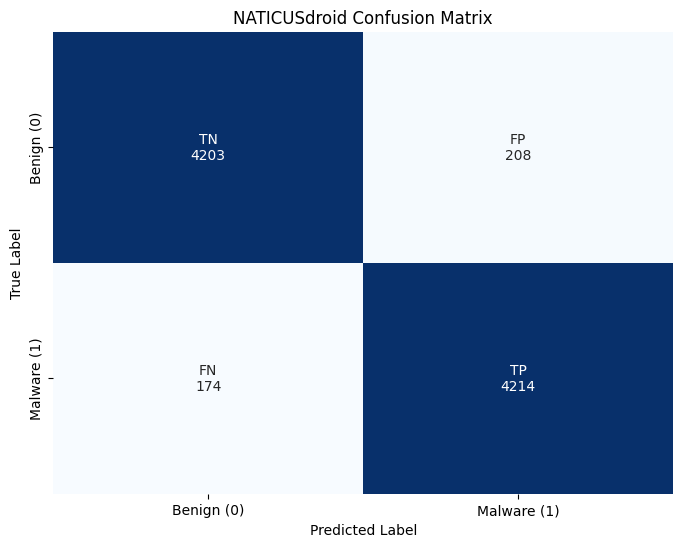

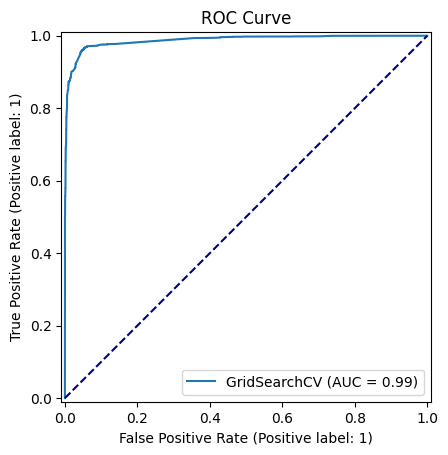

In [34]:
evaluate(model=logistic_regression_model, X=X_test, y=y_test)
evaluate(model=logistic_regression_model_2, X=X_test_2, y=y_test_2)